In [229]:
import git
from git import Repo

from unidiff import PatchSet

import subprocess
import json
import pandas as pd
import numpy as np
import matplotlib
import sys
import matplotlib.pyplot as plt
import sklearn

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.ensemble import ExtraTreesClassifier

In [230]:
mutants_and_tests = pd.read_pickle('flask_full_with_edit_distances_and_context.pkl')
len(mutants_and_tests)
display(mutants_and_tests)
print(mutants_and_tests.columns)

,mutant_id,contains_branch_mutant,contains_equality_comparison_mutant,contains_loop_mutant,contains_math_operands_mutant,current_line,line_number_changed,modified_file_path,modified_method,previous_line,...,setup_duration,call_outcome,call_duration,teardown_outcome,teardown_duration,contains_branch_execution,contains_loop_execution,contains_math_operands_execution,contains_equality_comparison_execution,edit_distance_method_name_test_name
0,1977.0,1.0,0.0,0.0,1.0,"key = ""XX mXX""",175.0,src/flask/json/tag.py,TagMarkup,,...,0.031885,True,0.000806,True,0.000296,False,False,True,False,9
1,1977.0,1.0,0.0,0.0,1.0,"key = ""XX mXX""",175.0,src/flask/json/tag.py,TagMarkup,,...,0.001572,True,0.000364,True,0.000240,False,True,False,False,9
2,1977.0,1.0,0.0,0.0,1.0,"key = ""XX mXX""",175.0,src/flask/json/tag.py,TagMarkup,,...,0.000355,True,0.000237,True,0.000219,False,True,False,False,9
3,1977.0,1.0,0.0,0.0,1.0,"key = ""XX mXX""",175.0,src/flask/json/tag.py,TagMarkup,,...,0.001527,True,0.000934,True,0.000243,False,False,False,True,9
4,1977.0,1.0,0.0,0.0,1.0,"key = ""XX mXX""",175.0,src/flask/json/tag.py,TagMarkup,,...,0.001606,True,0.000288,True,0.000238,False,False,False,True,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
958036,2092.0,1.0,1.0,0.0,1.0,"mimetype=current_app.config[""XXJSONIFY_...",336.0,src/flask/json/__init__.py,jsonify,,...,0.001344,True,0.001591,True,0.000247,False,False,False,False,7
958037,2092.0,1.0,1.0,0.0,1.0,"mimetype=current_app.config[""XXJSONIFY_...",336.0,src/flask/json/__init__.py,jsonify,,...,0.001295,True,0.002982,True,0.000226,False,False,False,False,7
958038,2092.0,1.0,1.0,0.0,1.0,"mimetype=current_app.config[""XXJSONIFY_...",336.0,src/flask/json/__init__.py,jsonify,,...,0.001311,True,0.001594,True,0.000247,False,False,False,False,7
958039,2092.0,1.0,1.0,0.0,1.0,"mimetype=current_app.config[""XXJSONIFY_...",336.0,src/flask/json/__init__.py,jsonify,,...,0.001978,True,0.001632,True,0.000247,False,False,False,False,7


Index(['mutant_id', 'contains_branch_mutant',
       'contains_equality_comparison_mutant', 'contains_loop_mutant',
       'contains_math_operands_mutant', 'current_line', 'line_number_changed',
       'modified_file_path', 'modified_method', 'previous_line', 'repo_path',
       'outcome', 'test_id', 'full_name', 'name', 'filepath', 'duration',
       'setup_outcome', 'setup_duration', 'call_outcome', 'call_duration',
       'teardown_outcome', 'teardown_duration', 'contains_branch_execution',
       'contains_loop_execution', 'contains_math_operands_execution',
       'contains_equality_comparison_execution',
       'edit_distance_method_name_test_name'],
      dtype='object')


# Data Preparation

In [231]:
feature_columns = ["contains_branch_mutant", "contains_loop_mutant", "contains_math_operands_mutant", "contains_equality_comparison_mutant",
    "contains_branch_execution", "contains_loop_execution", "contains_math_operands_execution", "contains_equality_comparison_execution", "edit_distance_method_name_test_name", "current_line", "line_number_changed", "modified_file_path", "previous_line", "test_id", "name", "filepath", "modified_method", "mutant_id"]
# feature_columns = ["current_line", "line_number_changed", "modified_file_path", "previous_line", "test_id", "name", "filepath", "mutant_id"]
X = mutants_and_tests[feature_columns]
y = mutants_and_tests["outcome"]

# Throw out nan values:
X = X.loc[mutants_and_tests[feature_columns].isnull().any(axis=1) == False]
y = mutants_and_tests["outcome"].loc[mutants_and_tests[feature_columns].isnull().any(axis=1) == False]
y = y.astype('bool')
len(X)


554412

In [232]:
# Encode stuff we want to encode:
encoded_columns = ["modified_method", "modified_file_path", "name", "filepath", "current_line", "previous_line"]
#encoded_columns = ["name", "filepath", "modified_file_path", "current_line", "previous_line"]
# Encoding
from sklearn.preprocessing import OrdinalEncoder
enc = OrdinalEncoder()
X_enc = enc.fit_transform(X[encoded_columns])
i = 0
for column_name in encoded_columns:
    X[column_name] = X_enc[:,i]
    i += 1
X

,contains_branch_mutant,contains_loop_mutant,contains_math_operands_mutant,contains_equality_comparison_mutant,contains_branch_execution,contains_loop_execution,contains_math_operands_execution,contains_equality_comparison_execution,edit_distance_method_name_test_name,current_line,line_number_changed,modified_file_path,previous_line,test_id,name,filepath,modified_method,mutant_id
0,1.0,0.0,1.0,0.0,False,False,True,False,9,1482.0,175.0,9.0,0.0,0.0,25.0,0.0,17.0,1977.0
1,1.0,0.0,1.0,0.0,False,True,False,False,9,1482.0,175.0,9.0,0.0,1.0,250.0,0.0,17.0,1977.0
2,1.0,0.0,1.0,0.0,False,True,False,False,9,1482.0,175.0,9.0,0.0,2.0,251.0,0.0,17.0,1977.0
3,1.0,0.0,1.0,0.0,False,False,False,True,9,1482.0,175.0,9.0,0.0,3.0,159.0,0.0,17.0,1977.0
4,1.0,0.0,1.0,0.0,False,False,False,True,9,1482.0,175.0,9.0,0.0,4.0,11.0,0.0,17.0,1977.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
958036,1.0,0.0,1.0,1.0,False,False,False,False,7,977.0,336.0,8.0,0.0,463.0,101.0,16.0,145.0,2092.0
958037,1.0,0.0,1.0,1.0,False,False,False,False,7,977.0,336.0,8.0,0.0,464.0,81.0,16.0,145.0,2092.0
958038,1.0,0.0,1.0,1.0,False,False,False,False,7,977.0,336.0,8.0,0.0,465.0,138.0,16.0,145.0,2092.0
958039,1.0,0.0,1.0,1.0,False,False,False,False,7,977.0,336.0,8.0,0.0,466.0,142.0,16.0,145.0,2092.0


In [233]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=420, shuffle=False)
X_train

,contains_branch_mutant,contains_loop_mutant,contains_math_operands_mutant,contains_equality_comparison_mutant,contains_branch_execution,contains_loop_execution,contains_math_operands_execution,contains_equality_comparison_execution,edit_distance_method_name_test_name,current_line,line_number_changed,modified_file_path,previous_line,test_id,name,filepath,modified_method,mutant_id
0,1.0,0.0,1.0,0.0,False,False,True,False,9,1482.0,175.0,9.0,0.0,0.0,25.0,0.0,17.0,1977.0
1,1.0,0.0,1.0,0.0,False,True,False,False,9,1482.0,175.0,9.0,0.0,1.0,250.0,0.0,17.0,1977.0
2,1.0,0.0,1.0,0.0,False,True,False,False,9,1482.0,175.0,9.0,0.0,2.0,251.0,0.0,17.0,1977.0
3,1.0,0.0,1.0,0.0,False,False,False,True,9,1482.0,175.0,9.0,0.0,3.0,159.0,0.0,17.0,1977.0
4,1.0,0.0,1.0,0.0,False,False,False,True,9,1482.0,175.0,9.0,0.0,4.0,11.0,0.0,17.0,1977.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
645000,1.0,0.0,1.0,1.0,False,True,False,False,9,442.0,191.0,3.0,0.0,57.0,88.0,1.0,105.0,534.0
645001,1.0,0.0,1.0,1.0,False,False,True,False,9,442.0,191.0,3.0,0.0,58.0,79.0,1.0,105.0,534.0
645002,1.0,0.0,1.0,1.0,False,False,True,False,9,442.0,191.0,3.0,0.0,59.0,168.0,1.0,105.0,534.0
645003,1.0,0.0,1.0,1.0,False,False,True,False,9,442.0,191.0,3.0,0.0,60.0,167.0,1.0,105.0,534.0


In [227]:
# Decision Tree
from sklearn import tree
clf = tree.DecisionTreeClassifier(ccp_alpha=0.001)
clf.fit(X_train, y_train)

print(y_train.value_counts())
print(y_test.value_counts())
print(classification_report(y_test, clf.predict(X_test)))

True     340290
False     31166
Name: outcome, dtype: int64
True     154091
False     28865
Name: outcome, dtype: int64
              precision    recall  f1-score   support

       False       1.00      0.20      0.33     28865
        True       0.87      1.00      0.93    154091

    accuracy                           0.87    182956
   macro avg       0.93      0.60      0.63    182956
weighted avg       0.89      0.87      0.84    182956



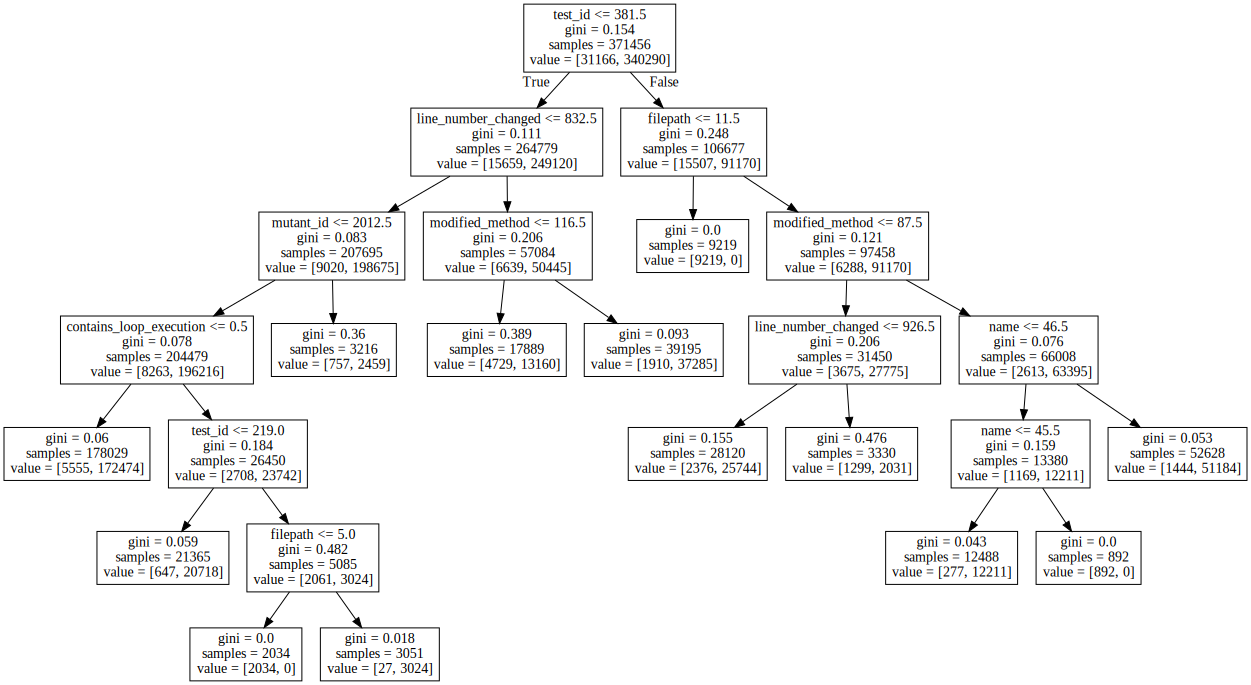

In [228]:
from graphviz import Source
from IPython.display import SVG
graph = Source(tree.export_graphviz(clf, out_file=None, feature_names=X.columns))
SVG(graph.pipe(format='svg'))

True     340290
False     31166
Name: outcome, dtype: int64
True     154091
False     28865
Name: outcome, dtype: int64
              precision    recall  f1-score   support

       False       0.89      0.26      0.40     28865
        True       0.88      0.99      0.93    154091

    accuracy                           0.88    182956
   macro avg       0.88      0.62      0.66    182956
weighted avg       0.88      0.88      0.85    182956

Feature ranking:
1. feature 13: contains_branch_mutant (0.187501)
2. feature 15: contains_loop_mutant (0.168306)
3. feature 14: contains_math_operands_mutant (0.140832)
4. feature 17: contains_equality_comparison_mutant (0.109315)
5. feature 9: contains_branch_execution (0.099117)
6. feature 10: contains_loop_execution (0.098018)
7. feature 16: contains_math_operands_execution (0.046335)
8. feature 8: contains_equality_comparison_execution (0.032414)
9. feature 7: edit_distance_method_name_test_name (0.027892)
10. feature 11: current_line (0.02467

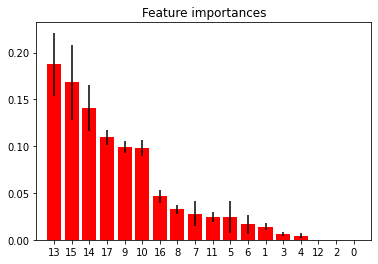

In [234]:
# Forest with semantics and context
forest = ExtraTreesClassifier(n_estimators=250,
                              random_state=420)

forest.fit(X_train, y_train)

print(y_train.value_counts())
print(y_test.value_counts())
prediction_with_semantics_and_context = forest.predict(X_test)
print(classification_report(y_test, prediction_with_semantics))

importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(X.shape[1]):
    print("%d. feature %d: %s (%f)" % (f + 1, indices[f], X.columns[f], importances[indices[f]]))

# Plot the impurity-based feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices],
        color="r", yerr=std[indices], align="center")
plt.xticks(range(X.shape[1]), indices)
plt.xlim([-1, X.shape[1]])
plt.show()

In [196]:
# Forest with semantics
forest = ExtraTreesClassifier(n_estimators=250,
                              random_state=420)

forest.fit(X_train[["edit_distance_method_name_test_name", "current_line", "line_number_changed", "modified_file_path", "previous_line", "test_id", "name", "filepath", "modified_method", "mutant_id"]], y_train)

print(y_train.value_counts())
print(y_test.value_counts())
prediction_with_semantics_and_context = forest.predict(X_test[["edit_distance_method_name_test_name", "current_line", "line_number_changed", "modified_file_path", "previous_line", "test_id", "name", "filepath", "modified_method", "mutant_id"]])
print(classification_report(y_test, prediction_with_semantics))

importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(X.shape[1]):
    print("%d. feature %d: %s (%f)" % (f + 1, indices[f], X.columns[f], importances[indices[f]]))

# Plot the impurity-based feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices],
        color="r", yerr=std[indices], align="center")
plt.xticks(range(X.shape[1]), indices)
plt.xlim([-1, X.shape[1]])
plt.show()

True     340290
False     31166
Name: outcome, dtype: int64
True     154091
False     28865
Name: outcome, dtype: int64


ValueError: Found input variables with inconsistent numbers of samples: [182956, 303630]

In [198]:
# Forest without semantics
forest = ExtraTreesClassifier(n_estimators=250,
                              random_state=420)

# Narrow down X_train and X_test

forest.fit(X_train[["current_line", "line_number_changed", "modified_file_path", "previous_line", "test_id", "name", "filepath", "mutant_id"]], y_train)

print(y_train.value_counts())
print(y_test.value_counts())
prediction_with_semantics = forest.predict(X_test[["current_line", "line_number_changed", "modified_file_path", "previous_line", "test_id", "name", "filepath", "mutant_id"]])
print(classification_report(y_test, prediction_without_semantics))


importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(X.shape[1]):
    print("%d. feature %d: %s (%f)" % (f + 1, indices[f], X.columns[f], importances[indices[f]]))

# Plot the impurity-based feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices],
        color="r", yerr=std[indices], align="center")
plt.xticks(range(X.shape[1]), indices)
plt.xlim([-1, X.shape[1]])
plt.show()

True     340290
False     31166
Name: outcome, dtype: int64
True     154091
False     28865
Name: outcome, dtype: int64


ValueError: Found input variables with inconsistent numbers of samples: [182956, 303630]

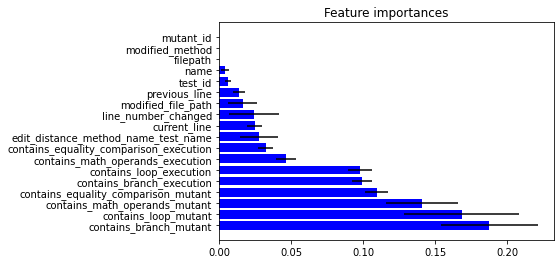

In [235]:
# Plot the impurity-based feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.barh(range(X.shape[1]), importances[indices],
        color="blue", xerr=std[indices], align="center")
plt.yticks(range(X.shape[1]), X.columns)
#plt.xlim([-1, X.shape[1]])
plt.show()

In [67]:
y_with_semantic_forest = forest.predict(X_test)

In [75]:
len(y_with_semantic_forest)


303630

In [69]:
print(np.bincount(y_without_semantic_forest))
print(np.bincount(y_with_semantic_forest))

[ 17536 298603]
[ 13695 289935]


In [189]:
#X_test['forest_with_seman_prediction'] = y_with_semantic_forest
X_test['forest_with_seman'] = prediction_with_semantics
X_test['forest_with_seman_and_context'] = prediction_with_semantics_and_context

<ipython-input-189-177968407010>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test['forest_with_seman_and_context'] = prediction_with_semantics_and_context


In [199]:
A = X_test.copy()
A['with_context_method_name'] = prediction_with_semantics_and_context
A['with_method_name'] = prediction_with_semantics
#A['without_method_name'] = prediction_without_semantics
A['outcome'] = y_test

In [209]:
print(A.loc[A['with_context_method_name'] == False].loc[A['with_method_name'] == True].loc[A['outcome'] == False].index[0:100])


Int64Index([714195, 724143, 724171, 724173, 724187, 724189, 724190, 724191,
            724193, 724194, 724214, 724454, 724464, 724485, 724486, 724611,
            724639, 724641, 724655, 724657, 724658, 724659, 724661, 724662,
            724682, 724922, 724932, 724953, 724954, 725079, 725107, 725109,
            725123, 725125, 725126, 725127, 725129, 725130, 725150, 725390,
            725400, 725421, 725422, 725547, 725575, 725577, 725618, 725889,
            725890, 727272, 729335, 729341, 729342, 729633, 729634, 729803,
            730271, 730739, 734490, 771909, 772377, 786336, 802095, 802097,
            802116, 802161, 802563, 802565, 802584, 802629, 857530, 864494,
            891171, 891223, 891224, 891225, 891226, 891227, 891228, 891229,
            891265, 891295, 891532, 893979, 894031, 894032, 894033, 894034,
            894035, 894036, 894037, 894073, 894103, 894385, 897255, 897312,
            897349, 897351, 897661, 900063],
           dtype='int64')


In [204]:
A.loc[905659]

contains_branch_mutant                        1
contains_loop_mutant                          0
contains_math_operands_mutant                 1
contains_equality_comparison_mutant           1
contains_branch_execution                  True
contains_loop_execution                   False
contains_math_operands_execution          False
contains_equality_comparison_execution     True
edit_distance_method_name_test_name           9
current_line                               1454
line_number_changed                          40
modified_file_path                            6
previous_line                                 0
test_id                                      38
name                                        106
filepath                                      1
modified_method                              38
mutant_id                                   261
forest_with_seman_and_context             False
with_context_method_name                  False
with_method_name                        

In [219]:
mutants_and_tests.loc[802095]

mutant_id                                                                              1077
contains_branch_mutant                                                                    1
contains_equality_comparison_mutant                                                       1
contains_loop_mutant                                                                      0
contains_math_operands_mutant                                                             1
current_line                                         app_root = app.config["XXAPPLICATIO...
line_number_changed                                                                      53
modified_file_path                                                     src/flask/testing.py
modified_method                                                                    __init__
previous_line                                                                              
repo_path                                                                  /tmp/